In [258]:
%matplotlib inline
import scipy.io
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (TwoSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip
import nipype.interfaces.spm as spm
from nipype.interfaces.base import Bunch
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_glass_brain

In [259]:
from nipype.interfaces.base import traits
from nipype.interfaces.base import File

In [260]:
experiment_dir = '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/datasink/two_sample'
output_dir = '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/datasink/two_sample/datasink'
working_dir = '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/datasink/two_sample/workindir'

# Smoothing withds used during preprocessing
fwhm = [4]

#subject_list = ['sub-02','sub-03', 'sub-05', 'sub-06', 'sub-11', 'sub-14', 'sub-16', 'sub-19', 'sub-23', 'sub-24', 'sub-26', 'sub-27', 'sub-28', 'sub-29']

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_015']

#mask = "/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz"

In [261]:
# SPM standalone
matlab_cmd = '/usr/local/spm12/run_spm12.sh /usr/local/MCR/v713/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

In [262]:
level2estimate = Node(EstimateModel(spm_mat_file = '/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/datasink/two_sample/workindir/con_015/SPM.mat', estimation_method={'Classical': 1}),
                      name="twosampttestdes")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="twosampleconestimate")
con_1 = ('Musik','T', ['Group_{1}'],[1])
con_2 = ('Sound','T', ['Group_{2}'],[1])
con_3 = ('Musik>Sound','T',['Group_{1}','Group_{2}'],[1,-1])
con_4 = ('Sound>Musik','T',['Group_{1}','Group_{2}'],[-1,1])
level2conestimate.inputs.contrasts = [con_1,con_2,con_3,con_4]
level2conestimate.inputs.group_contrast = True

In [263]:
# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Change the substituion parameters for the datasink
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'ants_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [264]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='ants_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),  
                   ])



220314-15:20:15,474 nipype.workflow INFO:
	 Generated workflow graph: /media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/datasink/two_sample/workindir/ants_l2analysis/graph.png (graph2use=colored, simple_form=True).


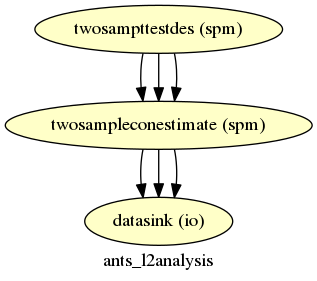

In [265]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'ants_l2analysis', 'graph.png'))

In [266]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 8})

220314-15:20:15,489 nipype.workflow INFO:
	 Workflow ants_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
220314-15:20:15,499 nipype.workflow INFO:
	 Running in parallel.
220314-15:20:15,502 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.21/28.21, Free processors: 8/8.
220314-15:20:15,741 nipype.workflow INFO:
	 [Node] Outdated cache found for "ants_l2analysis.twosampttestdes".
220314-15:20:15,789 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.twosampttestdes" in "/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/datasink/two_sample/workindir/ants_l2analysis/twosampttestdes".
220314-15:20:15,793 nipype.workflow INFO:
	 [Node] Outdated cache found for "ants_l2analysis.twosampttestdes".
220314-15:20:15,802 nipype.workflow INFO:
	 [Node] Running "twosampttestdes" ("nipype.interfaces.spm.model.EstimateModel")
220314-15:20:17,505 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs rea

/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


220314-15:20:27,750 nipype.workflow INFO:
	 [Node] Outdated cache found for "ants_l2analysis.twosampleconestimate".
220314-15:20:27,757 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.twosampleconestimate" in "/media/lmn/86A406A0A406933B6/HOAF/HOAF_BIDS/derivatives/secondlevel/datasink/two_sample/workindir/ants_l2analysis/twosampleconestimate".
220314-15:20:27,763 nipype.workflow INFO:
	 [Node] Outdated cache found for "ants_l2analysis.twosampleconestimate".
220314-15:20:27,782 nipype.workflow INFO:
	 [Node] Running "twosampleconestimate" ("nipype.interfaces.spm.model.EstimateContrast")
220314-15:20:29,515 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 28.01/28.21, Free processors: 7/8.
                     Currently running:
                       * ants_l2analysis.twosampleconestimate
220314-15:20:36,788 nipype.workflow INFO:
	 [Node] Finished "ants_l2analysis.twosampleconestimate".
220314-15:20:37,521 nipype.workflow INFO:
	 [Job 